# Analysis of endometriosis vs control samples across eutopic tissue (GSE179640)

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install leidenalg

In [4]:
adata_all = sc.read_h5ad("/home/katwre/projects/Endometriosis/data/processed/01_processed_qc_clustering_GSE179640_RAW.h5ad")

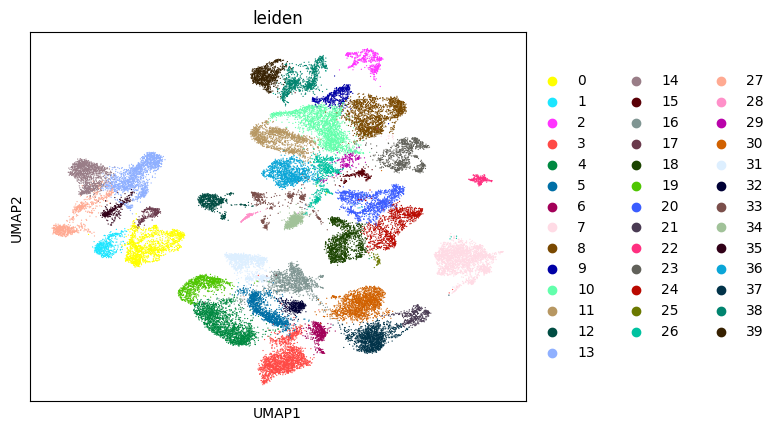

In [5]:
sc.pl.umap(adata_all, color="leiden")

In [7]:
# MArker genes from the GSE203191 (menstrual blood paper)
marker_genes = {
    "Uterine natural killer cells": [
        "PTPRC", "NCAM1"
    ],
    "Stromal cells": [
        "NT5E", "Thy1",  "CD90", "ENG"
    ],
    "CD4+ T cells": [
        "PTPRC", "CD3D", "CD3E", "CD4"
    ],
    "Myeloid cells": [
        "PTPRC", "CD14"
    ],
    "Epithelial cells": [
        "EPCAM"
    ],
    "CD8+ T cells": [
        "PTPRC", "CD3D", "CD3E", "CD8A"
    ],
    "B cells": [
        "PTPRC", "CD19", "MS4A1"
    ],
    "Plasmacytoid dendritic cells": [
        "PTPRC", "IL3RA", "CLEC4C", "LILRA4"
    ],
    "Endothelial-like cells": [
        "ENG", "PECAM1", "CD34"
    ],
    "Granulocytes": [
        "GCSAML", "CPA3"
    ],
    "Unknown Immune cells": [
        "PTPRC"
    ]
}

for celltype, genes in marker_genes.items():
    present = [g for g in genes if g in adata_all.var_names]
    missing = [g for g in genes if g not in adata_all.var_names]
    if missing:
        print(f"{celltype}:")
        print(f"  present: {present}")
        print(f"  missing: {missing}")

# Remove missing genes from marker list
marker_genes_filtered = {
    ct: [g for g in genes if g in adata_all.var_names]
    for ct, genes in marker_genes.items()
}

Stromal cells:
  present: ['NT5E', 'ENG']
  missing: ['Thy1', 'CD90']


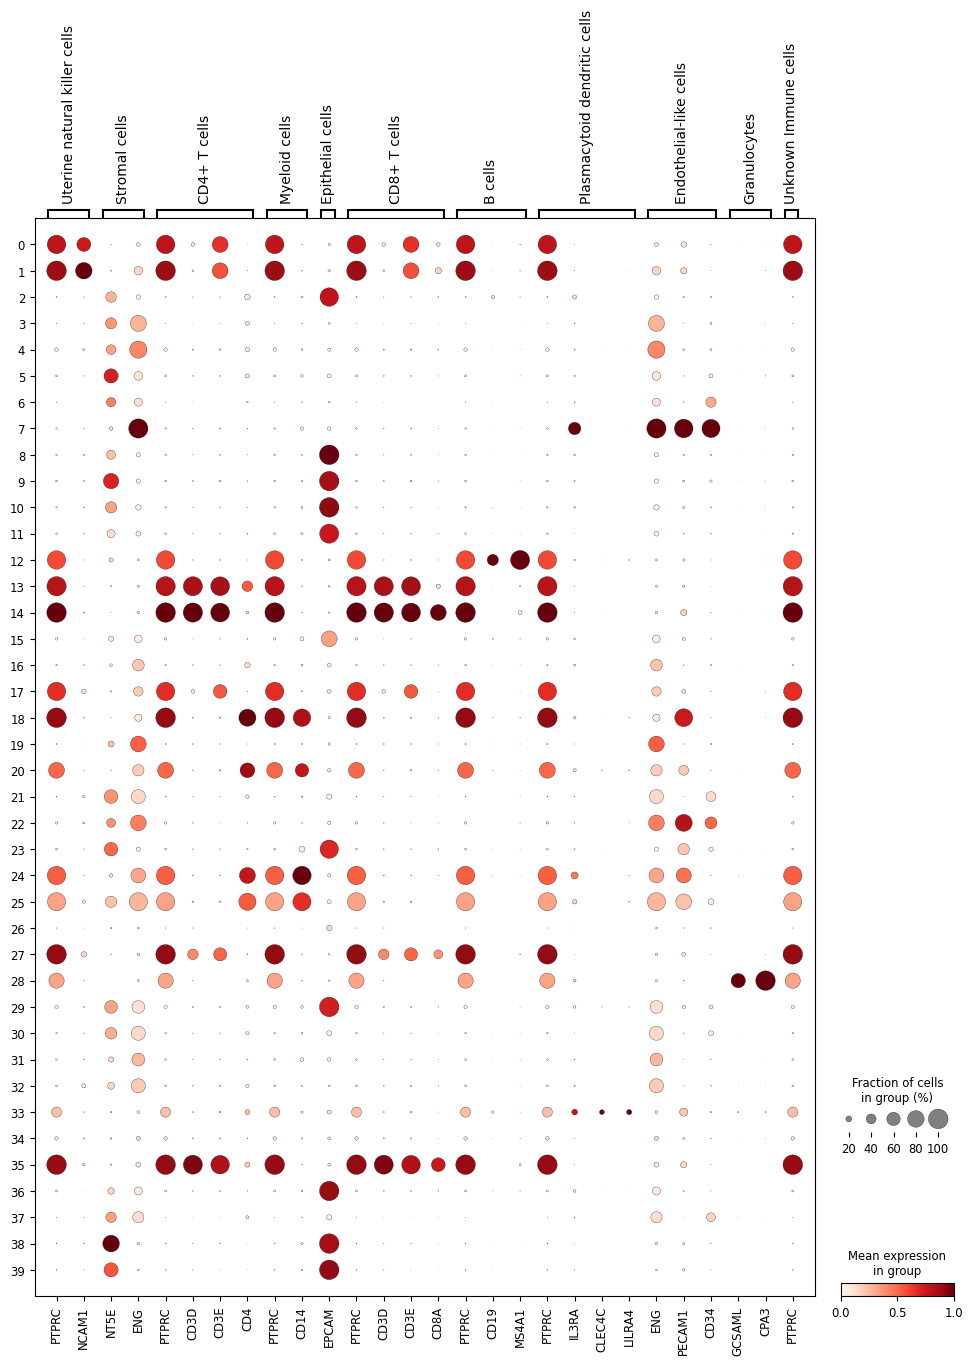

In [8]:
sc.pl.dotplot(
    adata_all,
    marker_genes_filtered,
    groupby="leiden",
    standard_scale="var"
)

In [9]:
# Make sure leiden is a string
adata_all.obs["leiden"] = adata_all.obs["leiden"].astype(str)

# Group mean expression for all genes
cluster_means = adata_all.to_df().groupby(adata_all.obs["leiden"]).mean()

scores = {}
for celltype, genes in marker_genes_filtered.items():
    present_genes = [g for g in genes if g in cluster_means.columns]
    # Mean expression across marker genes for each cluster
    scores[celltype] = cluster_means[present_genes].mean(axis=1)

scores = pd.DataFrame(scores)
#scores.head()
#plt.figure(figsize=(10, 13))
#sns.heatmap(
#    scores,
#    cmap="viridis",          # or "magma", "plasma", "coolwarm"
#    linewidths=0.5,
#    annot=True,              # write numbers in cells
#    fmt=".2f"
#)
#plt.title("Cluster × Cell-Type Marker Scores")
#plt.xlabel("Cell Type")
#plt.ylabel("Leiden Cluster")
#plt.tight_layout()
#plt.show()

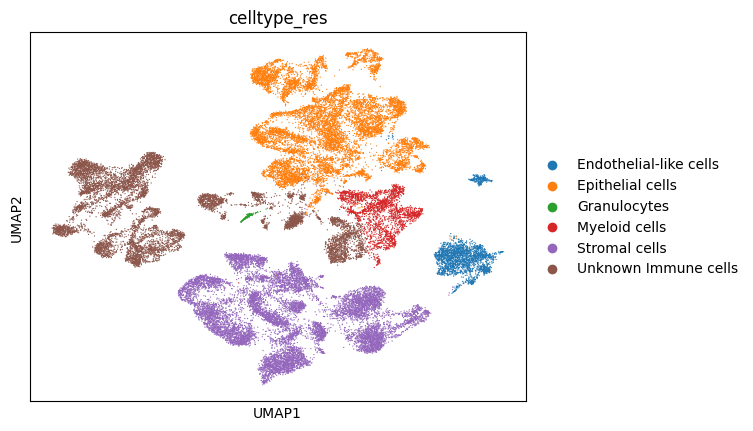

In [10]:
cluster_annotations = pd.DataFrame({
    "cluster": scores.index,
    "assigned_celltype": scores.idxmax(axis=1),
    "score": scores.max(axis=1),
})
#print(cluster_annotations)
# Create a dictionary mapping cluster → annotation
mapping = cluster_annotations.set_index("cluster")["assigned_celltype"].to_dict()
adata_all.obs["celltype_res"] = adata_all.obs["leiden"].map(mapping)
sc.pl.umap(adata_all, color="celltype_res")

In [11]:
# Add condition labels
adata_all.obs["condition"] = "Unknown"  
adata_all.obs.loc[
    adata_all.obs["sample"].str.contains("Ctrl"),
    "condition"
] = "Control"

adata_all.obs.loc[
    adata_all.obs["sample"].str.contains("EuE"),
    "condition"
] = "Endometriosis"

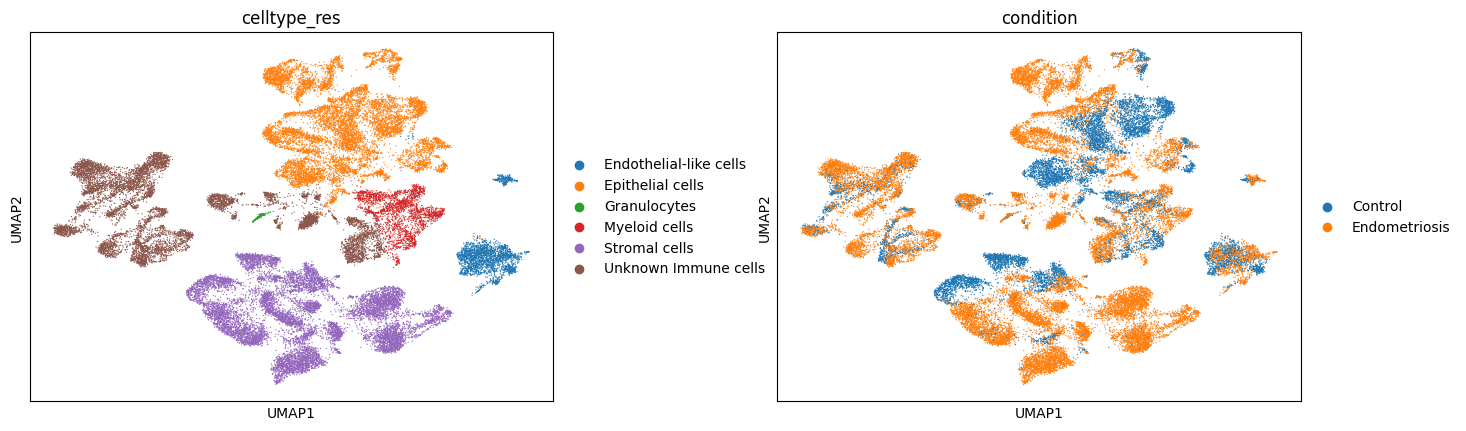

In [12]:
sc.pl.umap(
    adata_all,
    color=["celltype_res", "condition"],
    wspace=0.3,
    ncols=2
)

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqo

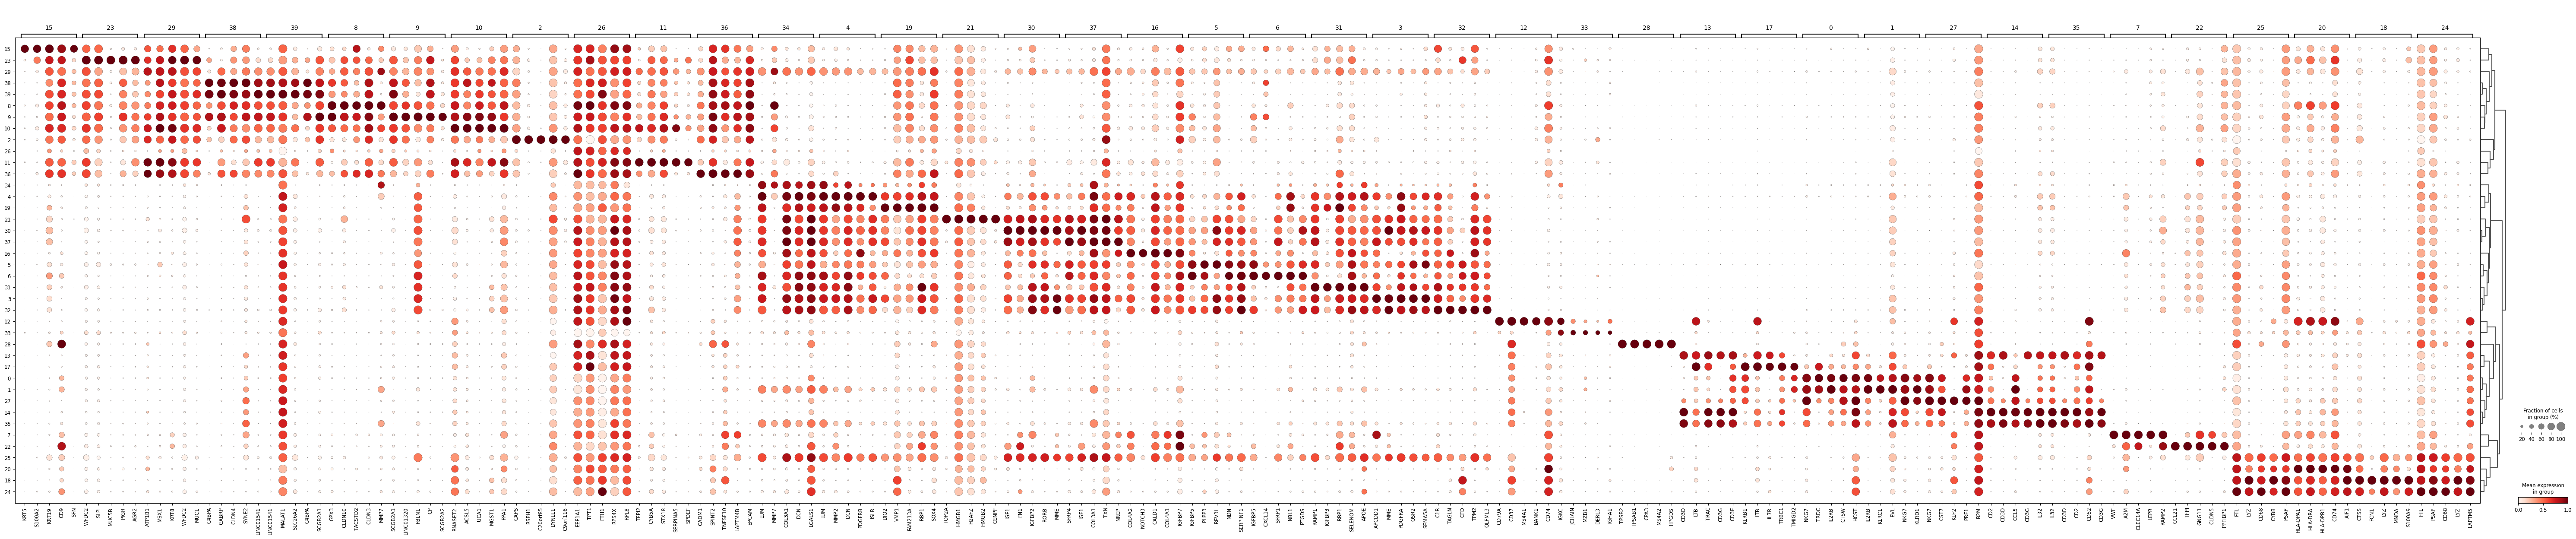

In [13]:
sc.tl.rank_genes_groups(adata_all, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata_all, groupby="leiden", standard_scale="var", n_genes=5)

Stromal cells represent the dominant cell population in the endometrium, and endometriosis pathology is known to manifest primarily through stromal dysfunction. Consequently, stromal cells carry the strongest and most reproducible “endometriosis signal.” They are also the only population that is consistently comparable across datasets: menstrual effluent (ME) samples such as GSE203191 have markedly different cell-type compositions from biopsy-based datasets like GSE179640, yet stromal cells are present in both. Immune and epithelial compartments vary widely between platforms and are heavily affected by batch effects and sample processing. If a classifier is trained on all cells together, it will mostly learn compositional differences (e.g., “many neutrophils = ME” or “many stromal cells = biopsy”) rather than true disease biology.

In [11]:
#adata_all.obs["celltype_res"].unique()
stromal = adata_all[adata_all.obs["celltype_res"] == "Stromal cells"].copy()

/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_18770/428219211.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(stromal, resolution=0.5)


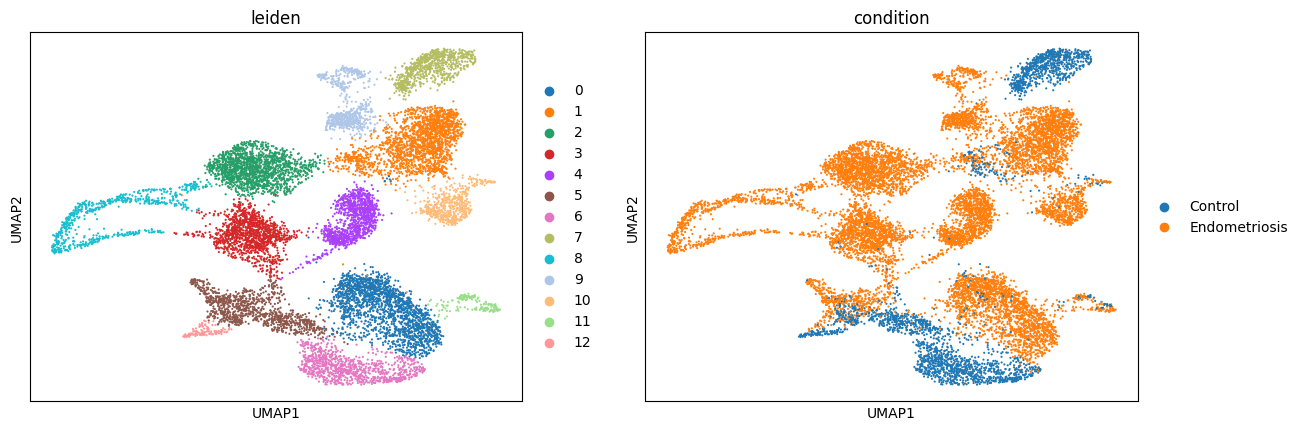

In [12]:
sc.pp.highly_variable_genes(stromal, flavor="seurat", n_top_genes=3000)
sc.pp.scale(stromal)
sc.tl.pca(stromal)
sc.pp.neighbors(stromal)
sc.tl.umap(stromal)
sc.tl.leiden(stromal, resolution=0.5)
sc.pl.umap(stromal, color=["leiden","condition"])

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib

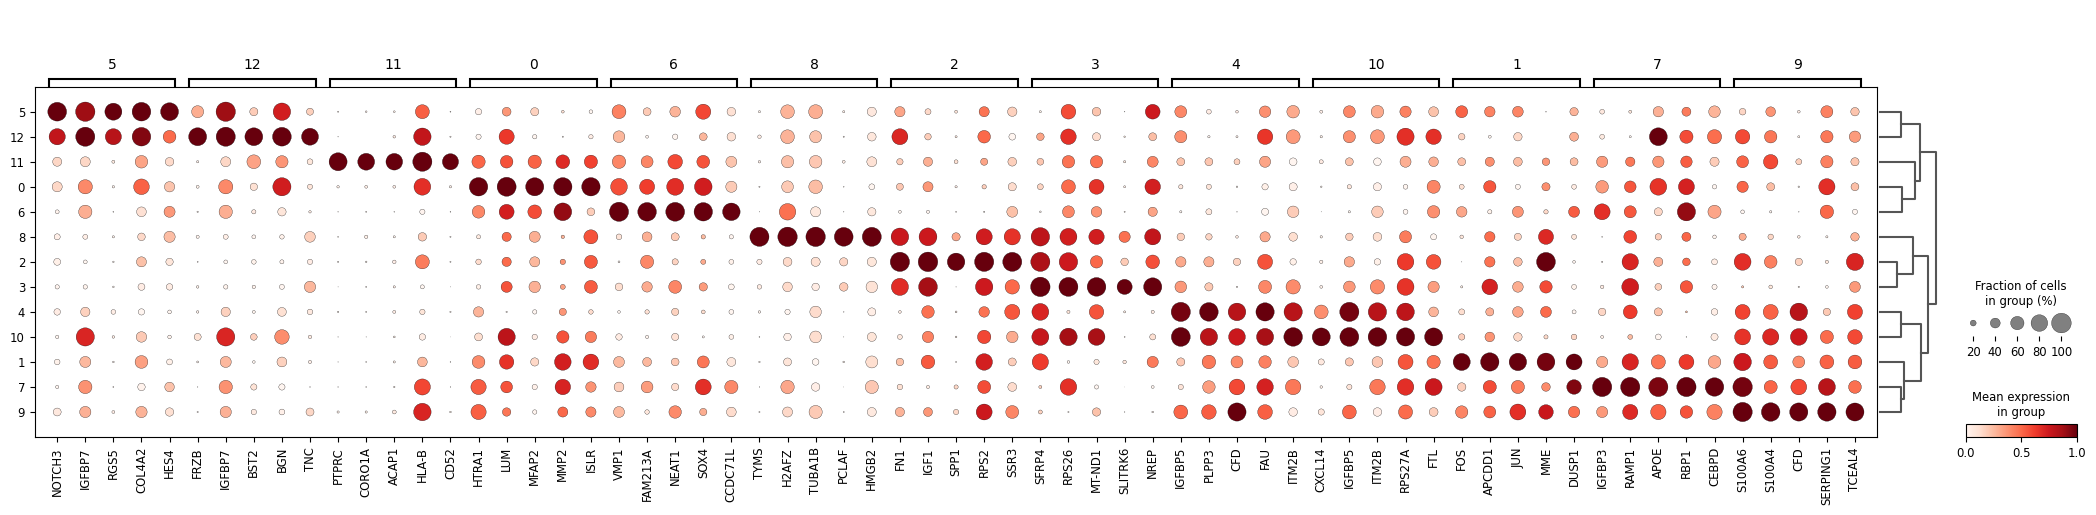

In [ ]:
# # Obtain cluster-specific differentially expressed genes - Wilcoxon rank-sum test.
sc.tl.rank_genes_groups(stromal, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(stromal, groupby="leiden", standard_scale="var", n_genes=5)

In [36]:
sc.get.rank_genes_groups_df(stromal, group="5").head(5)

names     scores  logfoldchanges  pvals  pvals_adj
0  NOTCH3  47.466564             NaN    0.0        0.0
1  IGFBP7  43.908916             NaN    0.0        0.0
2    RGS5  42.458031             NaN    0.0        0.0
3  COL4A2  42.082691             NaN    0.0        0.0
4    HES4  41.146107             NaN    0.0        0.0

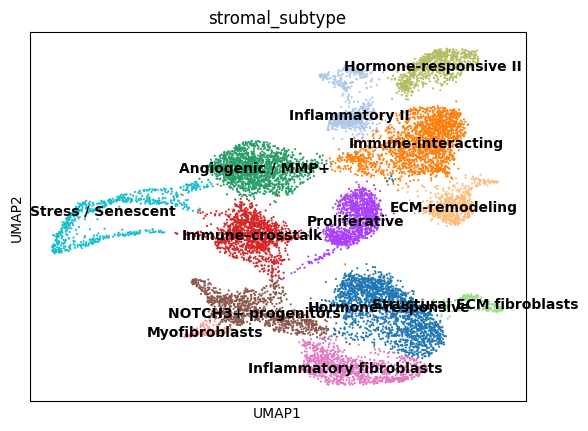

In [29]:
labels = {
    "0":  "Hormone-responsive",
    "1":  "Immune-interacting",
    "2":  "Angiogenic / MMP+",
    "3":  "Immune–crosstalk",
    "4":  "Proliferative",
    "5":  "NOTCH3+ progenitors",
    "6":  "Inflammatory fibroblasts",
    "7":  "Hormone-responsive II",
    "8":  "Stress / Senescent",
    "9":  "Inflammatory II",
    "10": "ECM-remodeling",
    "11": "Structural ECM fibroblasts",
    "12": "Myofibroblasts",
}

stromal.obs["stromal_subtype"] = stromal.obs["leiden"].map(labels)
sc.pl.umap(stromal, color="stromal_subtype", legend_loc="on data")

The stromal compartment resolves into several biologically meaningful fibroblast subtypes, consistent with known endometrial and endometriosis biology:

- Inflammatory fibroblasts – cytokine-producing, immune-interacting stromal cells that are expanded in endometriosis.
- Myofibroblasts – contractile, ACTA2⁺/TAGLN⁺ cells typically associated with lesion formation and tissue fibrosis.
- NOTCH3⁺ progenitor fibroblasts – perivascular, progenitor-like stromal cells involved in fibrosis, repair, and ECM remodeling.
- Hormone-responsive stromal cells – IGFBP1⁺/PRL⁺ decidual-like fibroblasts that are often dysregulated in endometriosis.
- Structural ECM fibroblasts – collagen-rich, matrix-producing cells representing the baseline stromal scaffold of the endometrium.

In [31]:
print(stromal)

AnnData object with n_obs × n_vars = 12572 × 27713
    obs: 'sample_id', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'celltype_res', 'condition', 'stromal_subtype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'predicted_doublet_col

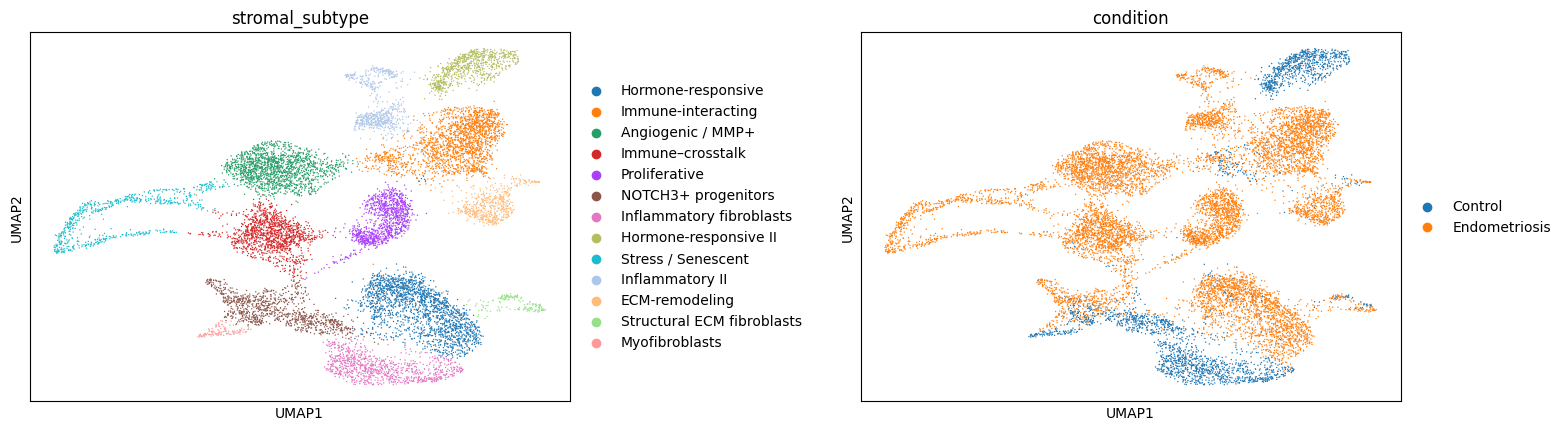

In [32]:
sc.pl.umap(
    stromal,
    color=["stromal_subtype", "condition"],
    wspace=0.4,
    ncols=2,
    size=4
)

In [35]:
stromal.obs.groupby(["stromal_subtype", "condition"]).size()

/tmp/ipykernel_18770/299000757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stromal.obs.groupby(["stromal_subtype", "condition"]).size()


stromal_subtype             condition    
Hormone-responsive          Control            68
                            Endometriosis    1833
Immune-interacting          Control            90
                            Endometriosis    1779
Angiogenic / MMP+           Control             0
                            Endometriosis    1564
Immune–crosstalk            Control            10
                            Endometriosis    1280
Proliferative               Control             3
                            Endometriosis    1104
NOTCH3+ progenitors         Control           521
                            Endometriosis     496
Inflammatory fibroblasts    Control           921
                            Endometriosis      28
Hormone-responsive II       Control           749
                            Endometriosis       8
Stress / Senescent          Control             1
                            Endometriosis     668
Inflammatory II             Control             1
        

Probably there is massive heterogeneity inside each condition, that's why I dont get the logfoldchanges after differential gene expression.

In [41]:
# 1. Start from your stromal AnnData
stromal_raw = stromal.copy()

# 2. Put raw counts into .X, then normalize + log1p
#    (you already have counts in a layer)
stromal_raw.X = stromal.layers["counts"].copy()

sc.pp.normalize_total(stromal_raw, target_sum=1e4)
sc.pp.log1p(stromal_raw)

# optional but nice: freeze this as .raw so scaling won't affect DE later
stromal_raw.raw = stromal_raw

# 3. Run DE: Endometriosis vs Control
sc.tl.rank_genes_groups(
    stromal_raw,
    groupby="condition",
    reference="Control",      # Control is baseline
    method="wilcoxon",
    key_added="de_condition"
)

# 4. Inspect DE table for Endometriosis
deg = sc.get.rank_genes_groups_df(
    stromal_raw,
    group="Endometriosis",
    key="de_condition"
)
deg.head(30)


names     scores  logfoldchanges          pvals      pvals_adj
0     RPL13A  52.434967        0.814071   0.000000e+00   0.000000e+00
1       IGF1  50.533432        2.822507   0.000000e+00   0.000000e+00
2      SFRP4  50.052528        3.512637   0.000000e+00   0.000000e+00
3      REV3L  46.800835        2.280646   0.000000e+00   0.000000e+00
4     PCOLCE  46.457191        1.566113   0.000000e+00   0.000000e+00
5      PLAC9  41.659477        3.623222   0.000000e+00   0.000000e+00
6      RPS20  41.091724        0.823389   0.000000e+00   0.000000e+00
7     NAP1L1  40.526421        1.118880   0.000000e+00   0.000000e+00
8     MT-CO3  40.110592        0.461592   0.000000e+00   0.000000e+00
9        MME  39.467613        2.011721   0.000000e+00   0.000000e+00
10      SSPN  38.465164        1.949955   0.000000e+00   0.000000e+00
11    MT-CO1  38.459969        0.488647   0.000000e+00   0.000000e+00
12    CRABP2  38.328594        2.409493   0.000000e+00   0.000000e+00
13     JAZF1  37.700085        2.667616   0.000000e+00   0.000000e+00
14      RPL7  37.597420        0.562865  2.368931e-309  2.984100e-306
15     MOXD1  37.585476        2.052486  3.712263e-309  4.472954e-306
16     RPS11  37.565361        0.515426  7.908981e-309  9.132566e-306
17     SFRP1  37.293095        2.012135  2.123534e-304  2.353980e-301
18     CCND2  37.256672        1.873839  8.262205e-304  8.806557e-301
19   CACNA1D  37.210789        2.180234  4.566856e-303  4.687455e-300
20    PGRMC1  36.965179        1.449077  4.154693e-299  3.970311e-296
21      GDF7  36.925377        1.912174  1.809872e-298  1.617967e-295
22    COL1A1  36.836124        1.384174  4.877820e-297  4.224344e-294
23       CKB  36.353420        2.149595  2.320364e-289  1.948613e-286
24  KCNQ1OT1  36.306751        1.623635  1.266036e-288  1.002447e-285
25    COL3A1  36.008949        0.964416  6.059500e-284  4.305819e-281
26  LGALS3BP  35.247513        1.322741  3.745652e-272  2.414029e-269
27      QPRT  35.125469        1.622367  2.754273e-270  1.734754e-267
28     RPS10  34.795635        0.736632  2.831424e-265  1.669516e-262
29      PEMT  34.760914        1.819843  9.482287e-265  5.474638e-262

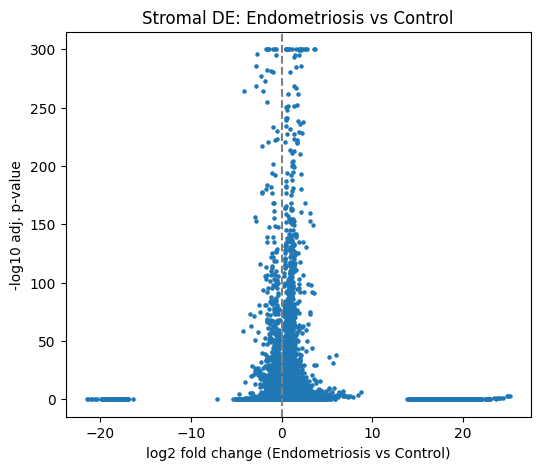

In [42]:

deg = sc.get.rank_genes_groups_df(
    stromal_raw, group="Endometriosis", key="de_condition"
)

# basic volcano
plt.figure(figsize=(6,5))
plt.scatter(
    deg["logfoldchanges"],
    -np.log10(deg["pvals_adj"] + 1e-300),  # avoid log10(0)
    s=5
)
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("log2 fold change (Endometriosis vs Control)")
plt.ylabel("-log10 adj. p-value")
plt.title("Stromal DE: Endometriosis vs Control")
plt.show()


In [43]:
hits = deg[
    (deg["pvals_adj"] < 0.05) &
    (deg["logfoldchanges"].abs() > 1)
].sort_values("logfoldchanges", ascending=False)

hits.head(30)


names     scores  logfoldchanges         pvals     pvals_adj
7179    AURKB   3.593724       25.114845  3.259854e-04  1.116140e-03
7605    BUB1B   3.276858       24.952335  1.049692e-03  3.401160e-03
7261     MELK   3.531896       24.802427  4.125912e-04  1.397817e-03
8774     NEK2   2.411273       24.359194  1.589696e-02  4.460838e-02
5313    UBE2C   5.225502        8.764475  1.736833e-07  8.012792e-07
6577    NCAPG   4.089695        8.400371  4.319411e-05  1.613694e-04
8338   PKMYT1   2.744676        7.811268  6.057059e-03  1.789545e-02
7137    MYBL2   3.625350        7.546763  2.885705e-04  9.944235e-04
7522    SPC25   3.346930        7.358167  8.171196e-04  2.676695e-03
8151    HJURP   2.883260        7.316455  3.935823e-03  1.189330e-02
7630   KIF20A   3.253937        7.102730  1.138177e-03  3.674545e-03
7032    CEP55   3.711210        6.829483  2.062708e-04  7.208552e-04
7074   PIMREG   3.680438        6.768031  2.328340e-04  8.089930e-04
4855    MKI67   5.651785        6.762048  1.587901e-08  7.990828e-08
6352      PBK   4.275368        6.736229  1.908221e-05  7.381703e-05
5971     ASPM   4.600223        6.538834  4.220386e-06  1.732221e-05
6504     ANLN   4.150478        6.353247  3.317811e-05  1.253702e-04
5287     RRM2   5.255753        6.292429  1.474204e-07  6.838738e-07
8086    MCM10   2.928562        6.257775  3.405336e-03  1.037626e-02
6888   SHCBP1   3.825626        6.066857  1.304402e-04  4.652366e-04
7119     HMMR   3.641857        6.005657  2.706786e-04  9.349763e-04
8563   KIF18B   2.565292        5.999617  1.030890e-02  2.963596e-02
836   SLC26A7  13.263176        5.969855  3.785190e-40  9.914837e-39
8598     POLQ   2.542042        5.910656  1.102069e-02  3.155780e-02
7585   CKAP2L   3.292327        5.881159  9.936202e-04  3.227781e-03
3981     PENK   6.520459        5.799589  7.009253e-11  4.271991e-10
8001    CDCA2   2.984666        5.661112  2.838878e-03  8.736770e-03
7547   DEPDC1   3.322688        5.647172  8.915456e-04  2.910520e-03
8163    CDCA8   2.874580        5.624810  4.045654e-03  1.220656e-02
1115    CALB2  11.953179        5.621981  6.248787e-33  1.262191e-31

In [53]:
hits.to_csv("/home/katwre/projects/Endometriosis/data/processed/stromal_DE_Endometriosis_vs_Control_GSE179640_RAW.csv", index=False)

Some genes have extremely high logFC (±20+). These are cluster-specific genes, not true condition DE genes. Probably from uncorrected confounding (e.g., underlying stromal subtype imbalance). I am not going to go in details of it for now, I will focus less on biology and more on ML part of this toy project.

In [ ]:
adata_all.write_h5ad(
    "/home/katwre/projects/Endometriosis/data/processed/02_control_disease_stromal_cells_GSE179640_RAW.h5ad"
)

# Immune cell composition related to menstrual blood annotation from GSE203191

In [19]:
marker_genes

{'Uterine natural killer cells': ['PTPRC', 'NCAM1'],
 'Stromal cells': ['NT5E', 'Thy1', 'CD90', 'ENG'],
 'CD4+ T cells': ['PTPRC', 'CD3D', 'CD3E', 'CD4'],
 'Myeloid cells': ['PTPRC', 'CD14'],
 'Epithelial cells': ['EPCAM'],
 'CD8+ T cells': ['PTPRC', 'CD3D', 'CD3E', 'CD8A'],
 'B cells': ['PTPRC', 'CD19', 'MS4A1'],
 'Plasmacytoid dendritic cells': ['PTPRC', 'IL3RA', 'CLEC4C', 'LILRA4'],
 'Endothelial-like cells': ['ENG', 'PECAM1', 'CD34'],
 'Granulocytes': ['GCSAML', 'CPA3'],
 'Unknown Immune cells': ['PTPRC']}

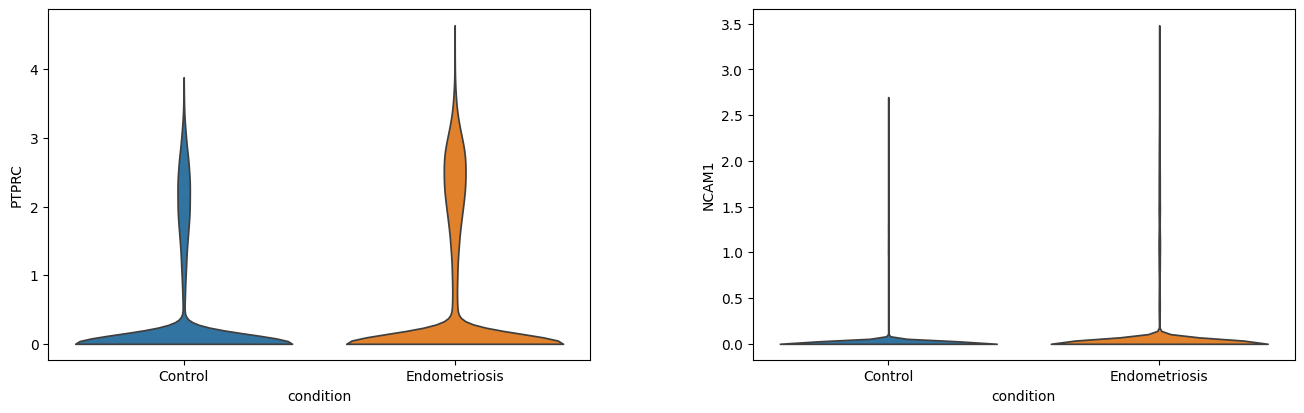

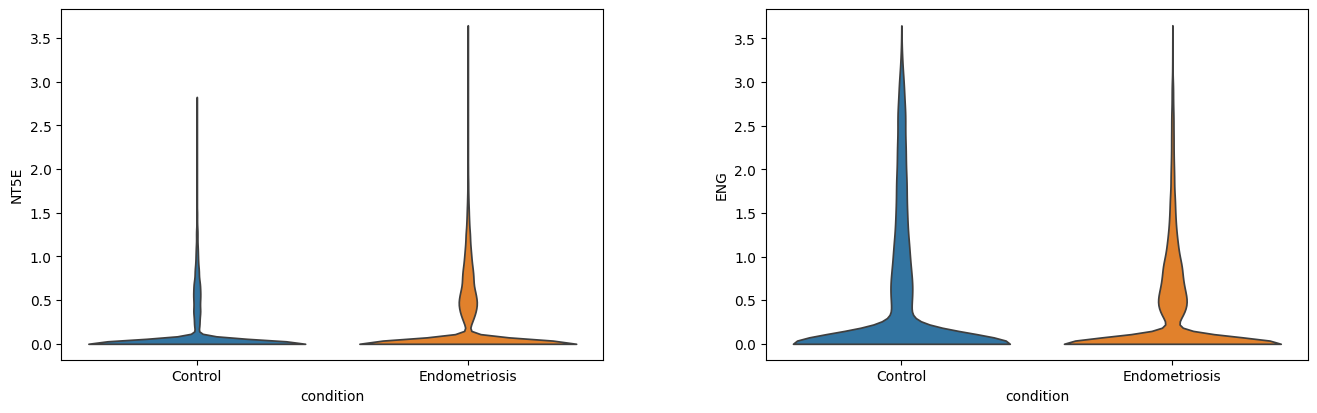

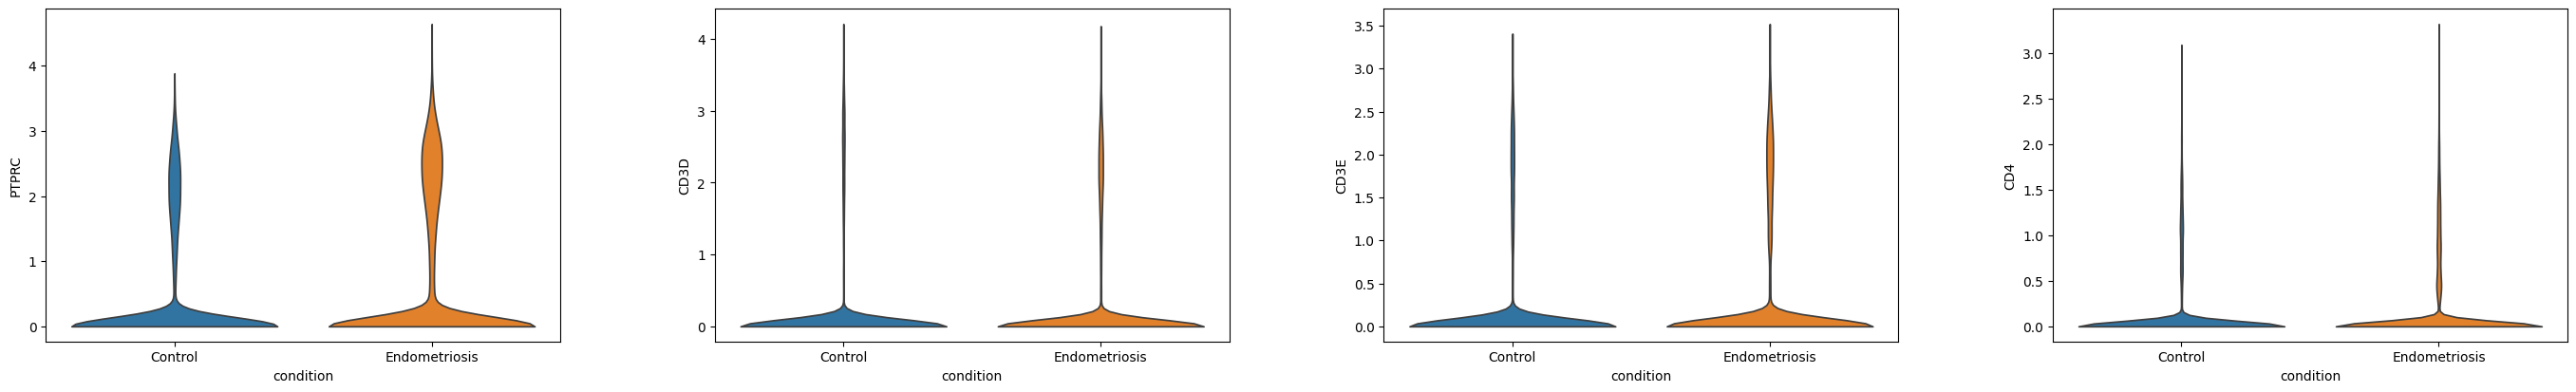

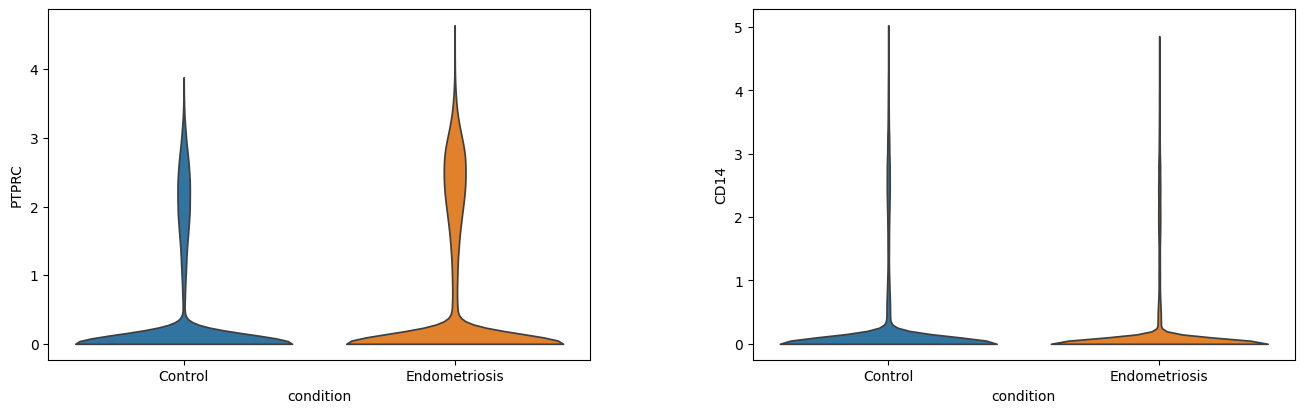

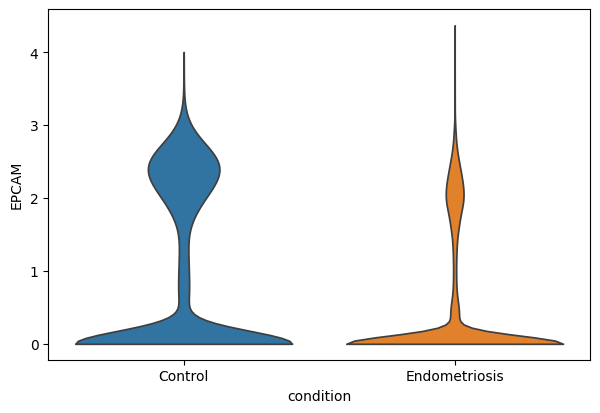

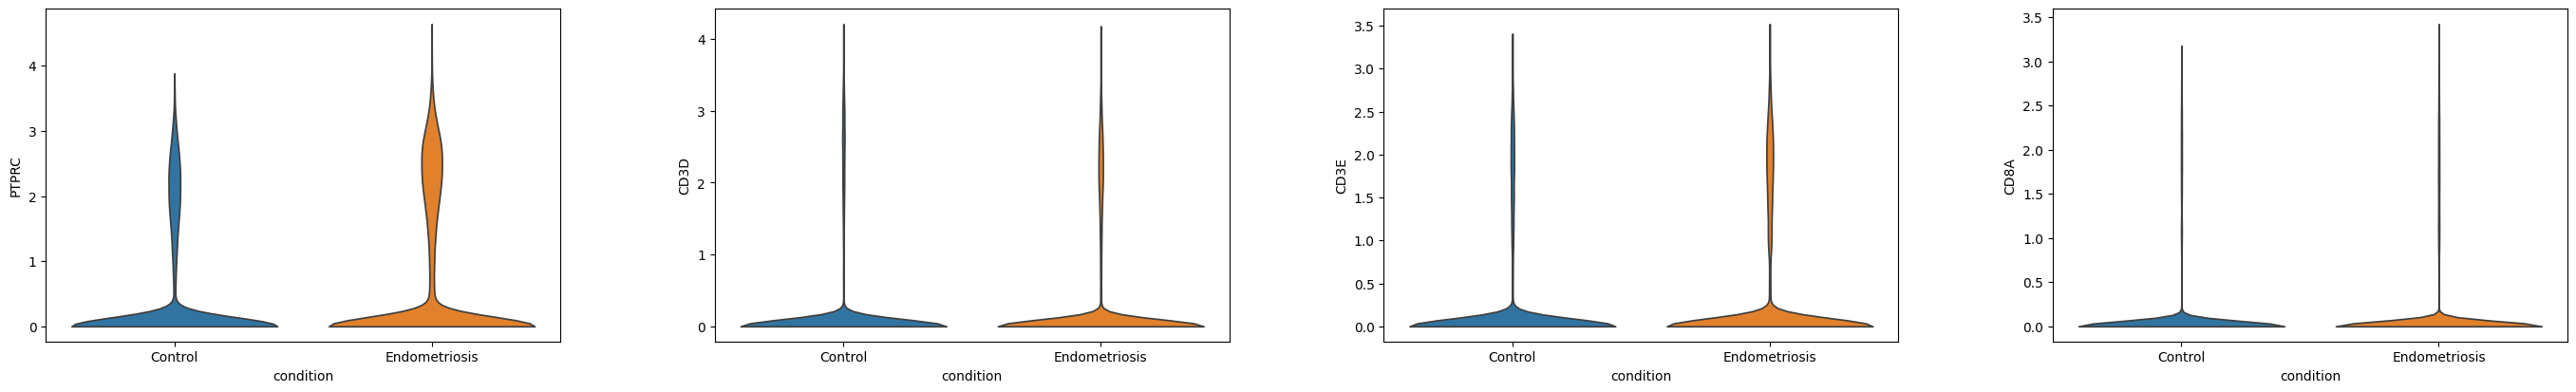

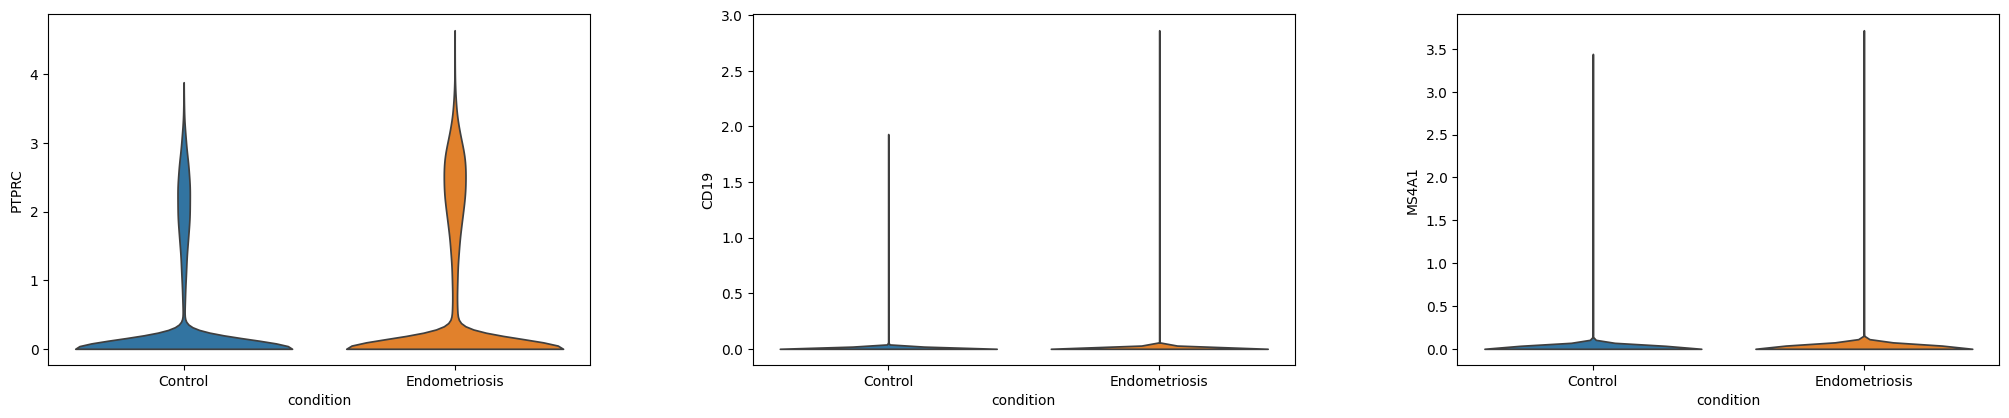

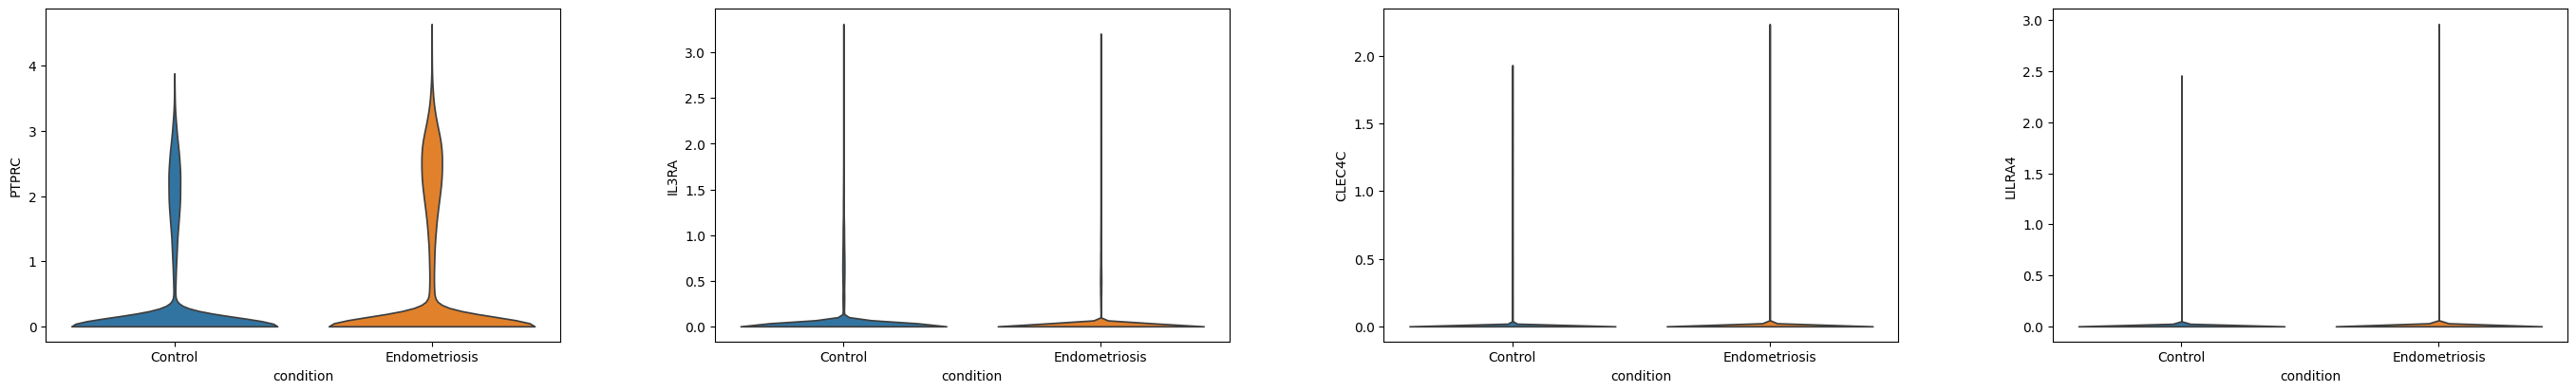

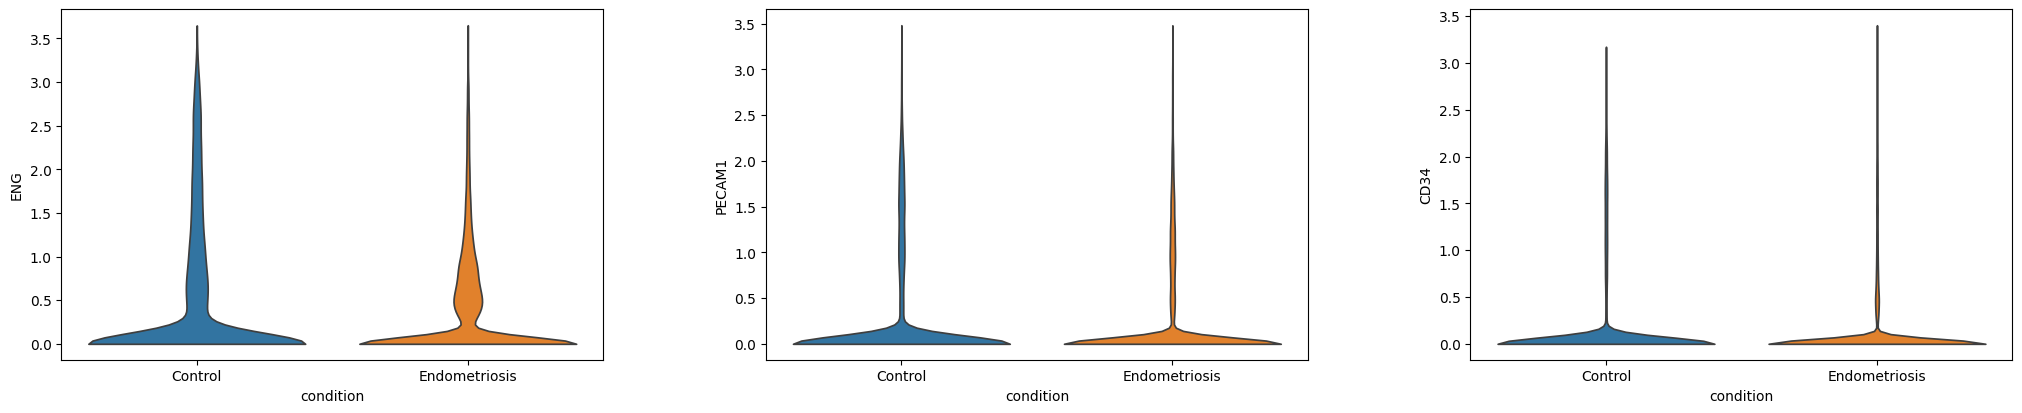

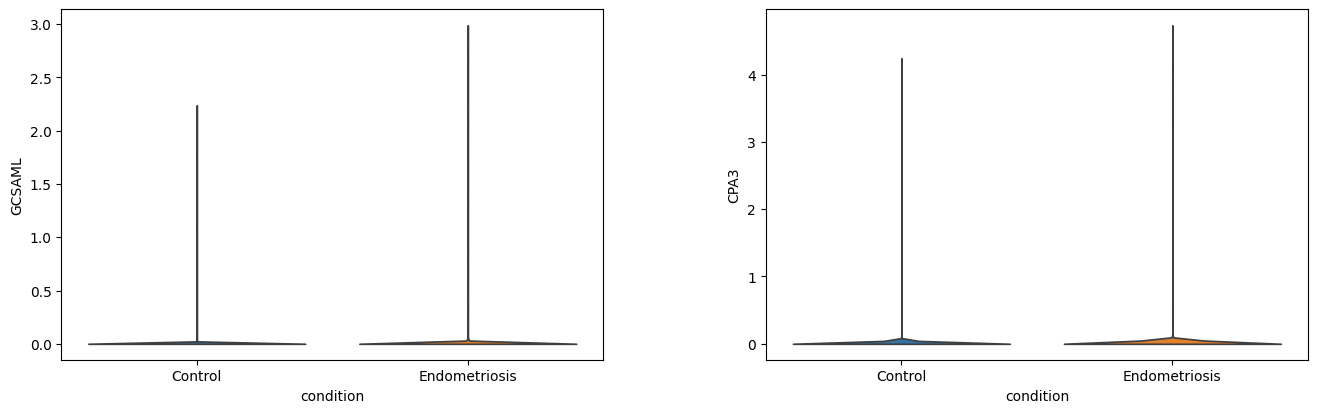

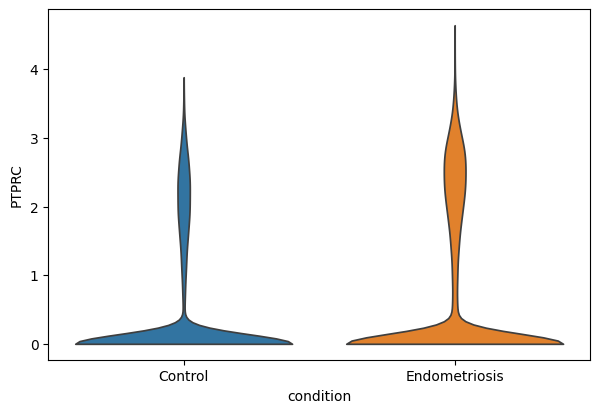

In [ ]:
for cellgroup, genes in marker_genes.items():
    genes_present = [g for g in genes if g in adata_all.var_names]
    
    if len(genes_present) == 0:
        continue
    
    sc.pl.violin(
        adata_all,
        keys=genes_present,
        groupby="condition",
        stripplot=False,
        jitter=False,
        multi_panel=True,
        layer="log2",
        #title=f"{cellgroup} marker genes"
    )

# Use celltypist for cell type annotation


In [ ]:
# Use celltypist for cell type annotation
#!pip install celltypist

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (37 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.4 MB/s  0:00:016.5 MB/s eta 0:00:010:01
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (153 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.11.12-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [celltypist] 5/6 [celltypist]


In [20]:
import celltypist
from celltypist import models

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/celltypist/classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


In [21]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 59
📂 Storing models in /home/katwre/.celltypist/data/models
💾 Downloading model [1/59]: Immune_All_Low.pkl
💾 Downloading model [2/59]: Immune_All_High.pkl
💾 Downloading model [3/59]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/59]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/59]: Adult_Human_MTG.pkl
💾 Downloading model [6/59]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/59]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/59]: Adult_Human_Skin.pkl
💾 Downloading model [9/59]: Adult_Human_Vascular.pkl
💾 Downloading model [10/59]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/59]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/59]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/59]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/59]: Adult_cHSPCs_Illumina.pkl
💾 Downloading model [15/59]: Adult_cHSPCs_Ultima.pkl
💾 Do

In [22]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


model  \
0                        Immune_All_Low.pkl   
1                       Immune_All_High.pkl   
2                    Adult_COVID19_PBMC.pkl   
3   Adult_CynomolgusMacaque_Hippocampus.pkl   
4                       Adult_Human_MTG.pkl   
5           Adult_Human_PancreaticIslet.pkl   
6          Adult_Human_PrefrontalCortex.pkl   
7                      Adult_Human_Skin.pkl   
8                  Adult_Human_Vascular.pkl   
9                       Adult_Mouse_Gut.pkl   
10            Adult_Mouse_OlfactoryBulb.pkl   
11                Adult_Pig_Hippocampus.pkl   
12      Adult_RhesusMacaque_Hippocampus.pkl   
13                Adult_cHSPCs_Illumina.pkl   
14                  Adult_cHSPCs_Ultima.pkl   
15                 Autopsy_COVID19_Lung.pkl   
16         COVID19_HumanChallenge_Blood.pkl   
17             COVID19_Immune_Landscape.pkl   
18                   Cells_Adult_Breast.pkl   
19                     Cells_Fetal_Lung.pkl   
20                   Cells_Human_Tonsil.pkl   
21               Cells_Intestinal_Tract.pkl   
22                    Cells_Lung_Airway.pkl   
23               Developing_Human_Brain.pkl   
24              Developing_Human_Gonads.pkl   
25         Developing_Human_Hippocampus.pkl   
26              Developing_Human_Organs.pkl   
27              Developing_Human_Thymus.pkl   
28               Developing_Mouse_Brain.pkl   
29         Developing_Mouse_Hippocampus.pkl   
30            Fetal_Human_AdrenalGlands.pkl   
31                 Fetal_Human_Pancreas.pkl   
32                Fetal_Human_Pituitary.pkl   
33                   Fetal_Human_Retina.pkl   
34                     Fetal_Human_Skin.pkl   
35                  Healthy_Adult_Heart.pkl   
36                 Healthy_COVID19_PBMC.pkl   
37                  Healthy_Human_Liver.pkl   
38                  Healthy_Mouse_Liver.pkl   
39          Human_AdultAged_Hippocampus.pkl   
40              Human_Colorectal_Cancer.pkl   
41           Human_Developmental_Retina.pkl   
42              Human_Embryonic_YolkSac.pkl   
43              Human_Endometrium_Atlas.pkl   
44                       Human_IPF_Lung.pkl   
45       Human_Longitudinal_Hippocampus.pkl   
46                     Human_Lung_Atlas.pkl   
47                        Human_PF_Lung.pkl   
48               Human_Placenta_Decidua.pkl   
49                  Lethal_COVID19_Lung.pkl   
50             Mouse_Dendritic_Subtypes.pkl   
51                  Mouse_Dentate_Gyrus.pkl   
52          Mouse_Isocortex_Hippocampus.pkl   
53         Mouse_Postnatal_DentateGyrus.pkl   
54                    Mouse_Whole_Brain.pkl   
55                   Nuclei_Lung_Airway.pkl   
56       PaediatricAdult_COVID19_Airway.pkl   
57         PaediatricAdult_COVID19_PBMC.pkl   
58                      Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   peripheral blood mononuclear cell types from C...  
3   cell types from the hippocampus of adult cynom...  
4   cell types and subtypes (10x-based) from the a...  
5   cell types from pancreatic islets of healthy a...  
6   cell types and subtypes from the adult human d...  
7            cell types from human healthy adult skin  
8   vascular populations combined from multiple ad...  
9   cell types in the adult mouse gut combined fro...  
10   cell types from the olfactory bulb of adult mice  
11          cell types from the adult pig hippocampus  
12  cell types from the hippocampus of adult rhesu...  
13  human circulating hematopoietic stem and proge...  
14  human circulating hematopoietic stem and proge...  
15  cell types from the lungs of 16 SARS-CoV-2 inf...  
16  detailed blood cell states from 16 individuals...  
17  immune subtypes from lung and blood of COVID-1...  
18             cell types from the adult human breast  
19    cell types from human embryonic and fetal lungs  
20      tonsillar cell types from humans 

In [35]:
# Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Human_Endometrium_Atlas.pkl')
model.cell_types

array(['Arterial', 'Ciliated', 'Cycling', 'Fibroblast_basalis',
       'Glandular', 'Glandular_secretory', 'Glandular_secretory_FGF7',
       'HOXA13', 'Immune_Lymphoid', 'Immune_Myeloid', 'KRT5', 'Luminal',
       'Lymphatic', 'MUC5B', 'SOX9_basalis', 'SOX9_functionalis_I',
       'SOX9_functionalis_II', 'SOX9_luminal', 'Venous', 'dHormones',
       'dStromal_early', 'dStromal_late', 'dStromal_mid', 'eHormones',
       'ePV_1a', 'ePV_1b', 'ePV_2', 'eStromal', 'eStromal_MMPs',
       'eStromal_cycling', 'mPV', 'preCiliated', 'preGlandular',
       'preLuminal', 'sHormones', 'uSMCs'], dtype=object)

In [36]:
predictions = celltypist.annotate(adata_all, model = 'Human_Endometrium_Atlas.pkl', majority_voting = True)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 37503 cells and 27713 genes
🔗 Matching reference genes in the model
🧬 3734 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


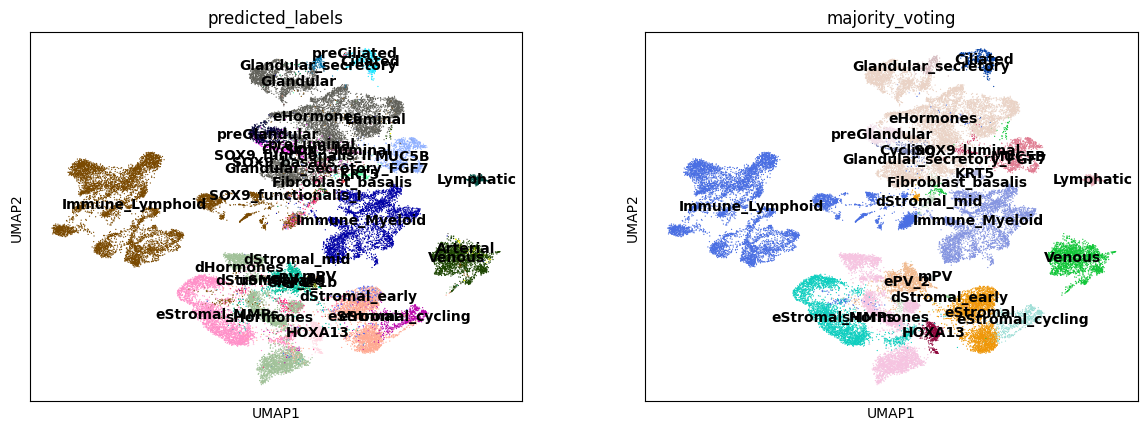

In [37]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 37503 cells and 27713 genes
🔗 Matching reference genes in the model
🧬 5865 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


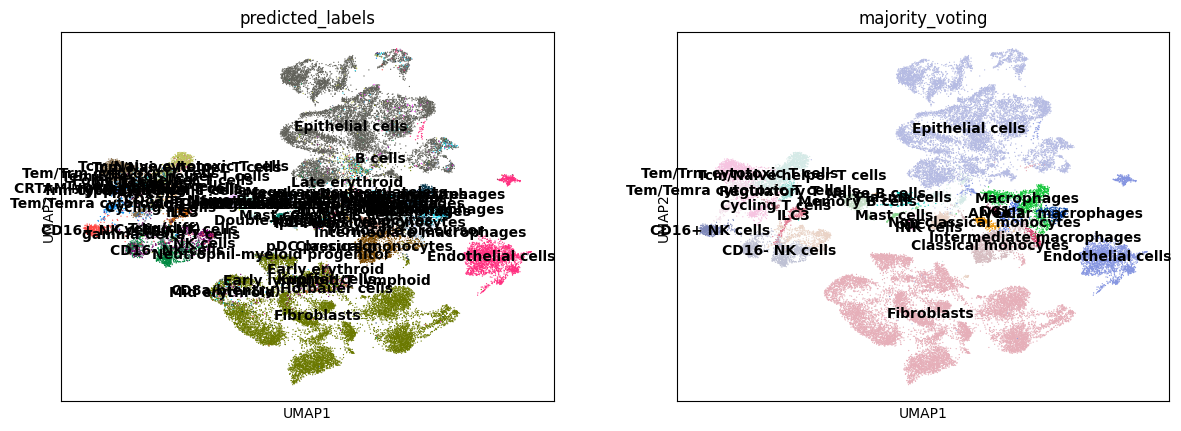

In [38]:
predictions = celltypist.annotate(adata_all, model = 'Immune_All_Low.pkl', majority_voting = True)
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

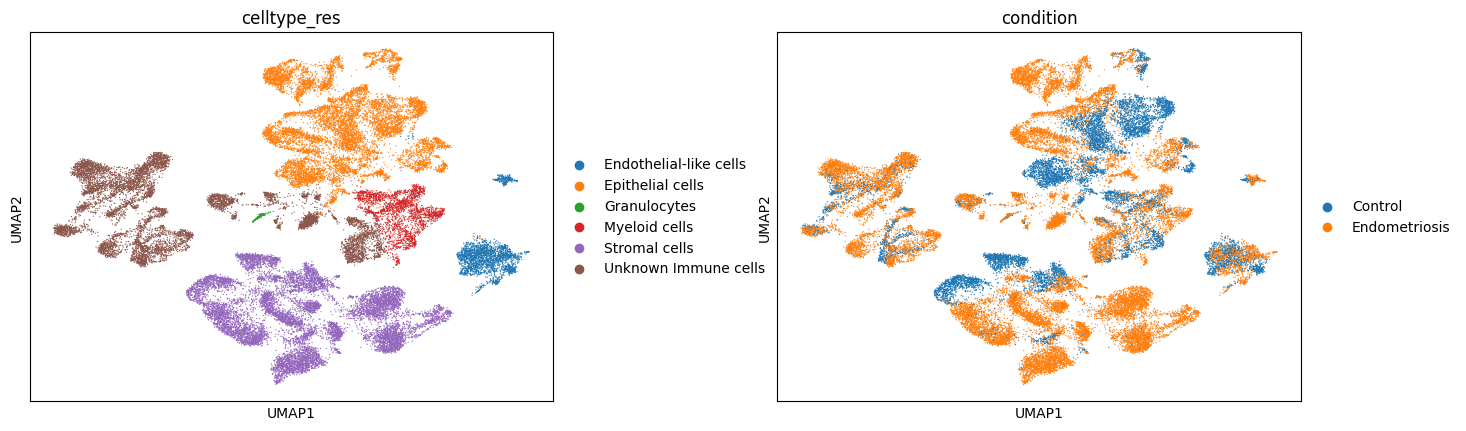

In [39]:
sc.pl.umap(
    adata_all,
    color=["celltype_res", "condition"],
    wspace=0.3,
    ncols=2
)